# Download requirements

In [ ]:
install.packages('fpp2')

In [1]:
library(fpp2)

Warning message:
"package 'fpp2' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
-- Attaching packages ---------------------------------------------- fpp2 2.4 --
v ggplot2   3.1.1     v fma       2.4  
v forecast  8.14      v expsmooth 2.3  
Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'fma' was built under R version 3.6.3"Warning message:
"package 'expsmooth' was built under R version 3.6.3"


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho Enrgy portfolio

#### Lấy dữ liệu của Enrgy porfolio

In [4]:
series <- ts(data = data$Enrgy, start = c(1963,7), end = c(2022,4), frequency = 12)

In [5]:
series %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-34.490  -2.317   0.915   1.023   4.393  32.380 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale

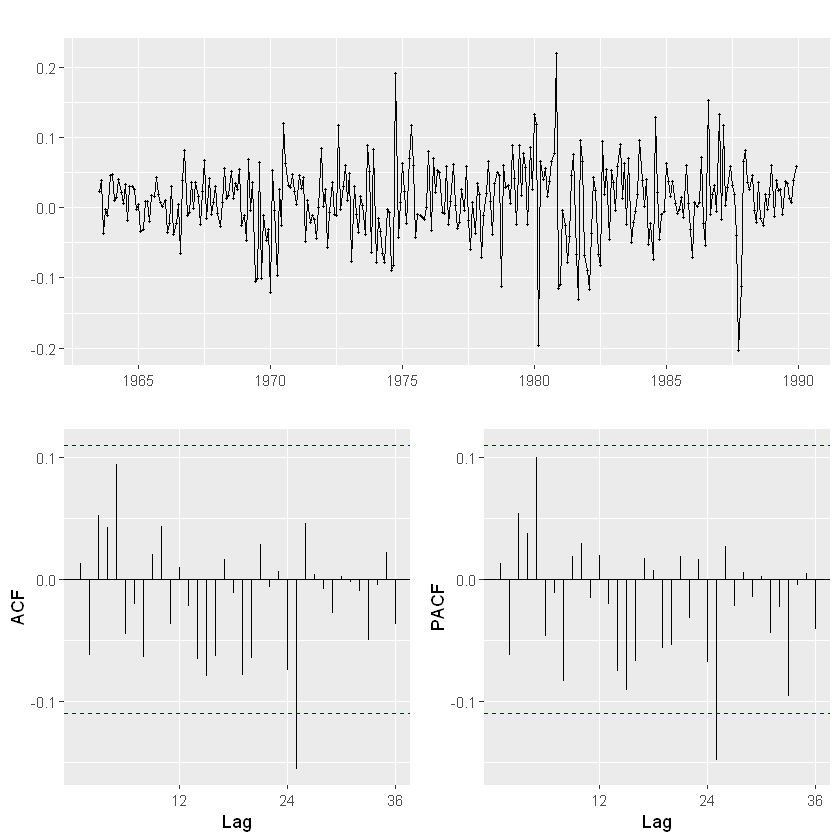

In [8]:
series_train %>% ggtsdisplay()

Biểu đồ dao động không có trend và seasonality quan sát được, nên không cần lấy difference và seasonal difference. <br>
Thử lại với hàm dò tìm bậc d: ndiffs cho order và nsdiffs cho seasonal.

In [9]:
series_train %>% ndiffs()

[1] 0

In [10]:
series_train %>% nsdiffs()

[1] 0

Kết quả d = 0 cho cả order và seasonal.

#### Phân tích p và q cho mô hình ARIMA

Thử dò tìm (p,d,q) với chế độ auto theo thuật toán Hyndman-Khandakar.

In [11]:
fit <- auto.arima(series_train, stepwise = FALSE, approximation = FALSE)
fit

Series: series_train 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      0.0098
s.e.  0.0030

sigma^2 estimated as 0.002927:  log likelihood=476.85
AIC=-949.69   AICc=-949.65   BIC=-942.17


	Ljung-Box test

data:  Residuals from ARIMA(0,0,0) with non-zero mean
Q* = 20.056, df = 23, p-value = 0.6385

Model df: 1.   Total lags used: 24



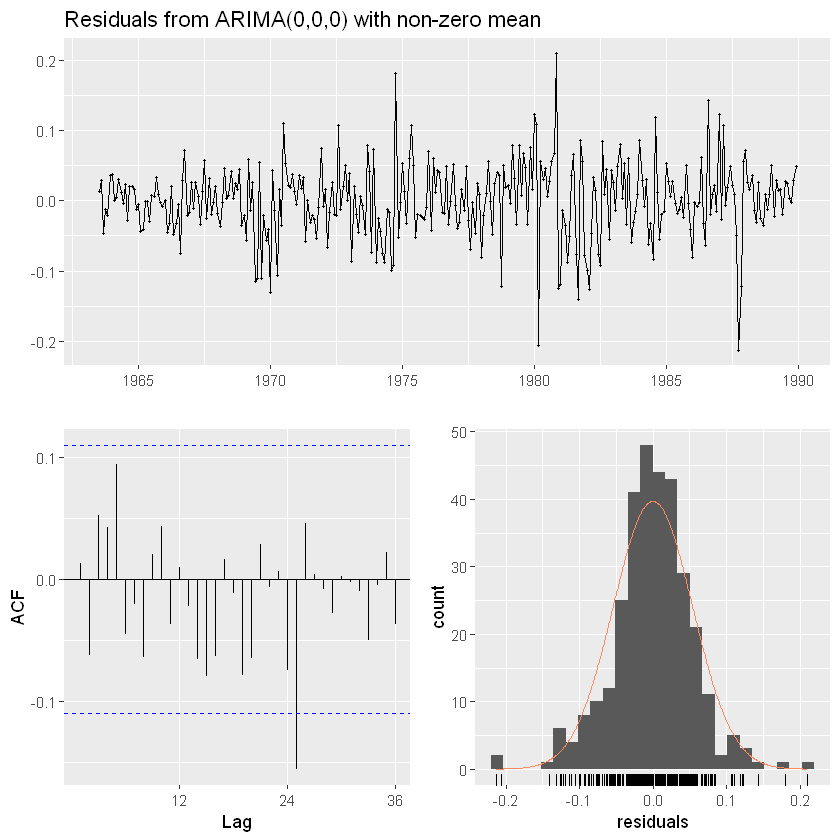

In [12]:
fit %>% checkresiduals()

Auto đề xuất ARIMA(0,0,0), Ljung-Box test cho p-value > 0.05 nên mô hình phù hợp.

Thử tất cả các mô hình đề xuất và so sánh theo tiêu chuẩn thông tin AIC, AICc, BIC, RMSE.

In [13]:
model <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), 
              ARIMA102 = c(1,0,2), ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2))

In [14]:
result <- NULL
for (m in model)
{
    fit <- Arima(series_train, order = m)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(model)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-949.6925,-949.6544,-942.1684,5.445807
ARIMA001,-947.7510,-947.6746,-936.4649,5.445671
ARIMA002,-946.9806,-946.8528,-931.9324,5.436342
ARIMA100,-947.7436,-947.6672,-936.4575,5.445682
ARIMA101,-948.2521,-948.1243,-933.2039,5.425019
ARIMA102,-946.9065,-946.7142,-928.0962,5.418764
ARIMA200,-946.9869,-946.8591,-931.9387,5.436145
ARIMA201,-946.9039,-946.7116,-928.0936,5.418719
ARIMA202,-944.9050,-944.6349,-922.3327,5.418707


Mô hình ARIMA(2,0,2) cho kết quả RMSE thấp nhất trên tập train.

#### Đánh giá mô hình ARIMA(2,0,2) trên tập test

In [7]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end = length(series)-388+i) %>% log_scale
    fit <- Arima(train, order = c(2,0,2))
    pred <- c(pred, forecast(fit, h = 1)$mean %>% log_inv) 
}
pred <- ts(data = pred, start = c(1990,1), frequency = 12)
true <- series %>% window(start = c(1990,1))
rmse <- sqrt(mean((true-pred)^2))
rmse

[1] 6.438896

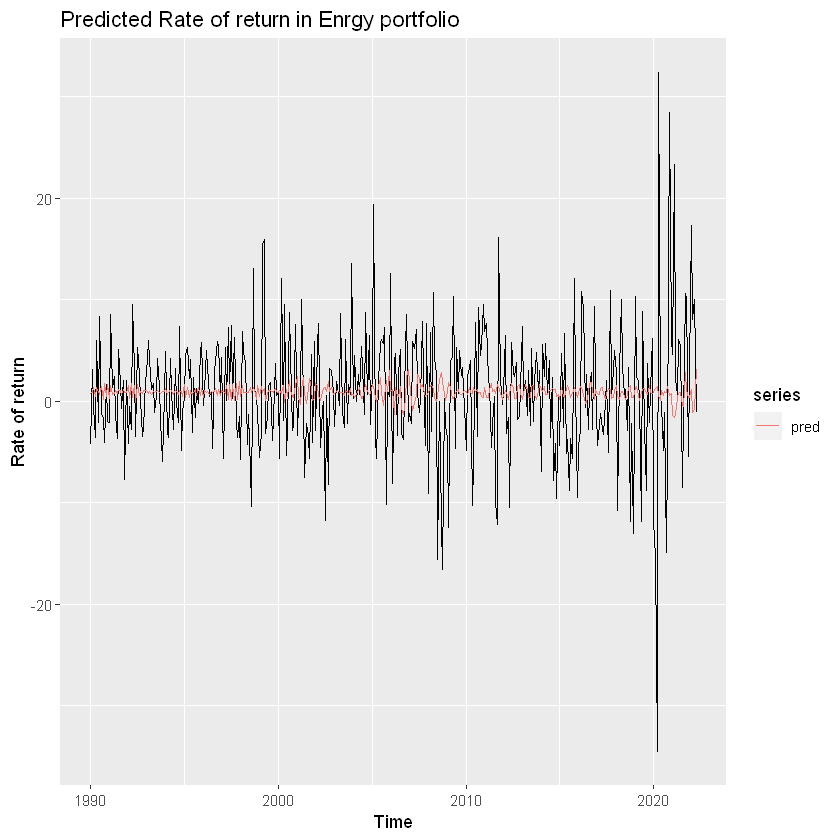

In [8]:
autoplot(true) + autolayer(pred) + labs(y = "Rate of return", title = "Predicted Rate of return in Enrgy portfolio")

In [9]:
as.numeric(pred)

[1]  0.73518779  0.82010556  1.40382075  0.49716024  1.34982714  0.96909093
  [7]  0.64058074  1.49360855  0.14547551  1.77514574  0.42400008  1.67161866
 [13]  0.32116360  1.58735999  0.63519856  0.80033842  1.07792006  0.76183570
 [19]  1.19954165  1.04320684  0.64719510  1.14375754  0.90690988  0.82938761
 [25]  1.56269880  0.32002927  1.70420669  0.32719665  1.59583000 -0.08307473
 [31]  1.63189170  0.59469807  0.94924469  0.81416721  1.05992311  1.06101779
 [37]  1.01972687  0.78176512  0.95733629  0.64546943  0.99400802  0.88513668
 [43]  0.92229091  1.06447336  0.88965941  0.80498355  1.00025674  0.96986822
 [49]  1.28105075  0.69881355  0.84757061  1.13958606  1.03463752  0.63895786
 [55]  1.08749661  1.00495237  0.69166696  1.11184915  0.97667328  0.44490151
 [61]  1.65333417  0.41980822  1.33198338  0.34403569  1.09142860  0.69403427
 [67]  0.88792091  1.20060046  0.59777565  1.33434210  0.54438299  1.30465182
 [73]  0.38914518  1.05972104  0.88830857  0.98523219  0.66497676  1.00365927
 [79]  0.91310905  0.92602944  1.30864845  0.53809453  1.11346448  0.55463017
 [85]  1.04757153  0.94840600  0.73401303  1.57117878  0.22055768  1.63059374
 [91]  0.07010099  1.68373843  0.06626621  1.76450906  0.13631172  1.91809862
 [97]  0.49559640  1.55797961  0.82344389  0.81979905  0.89249854  0.90724024
[103]  1.31622380  0.82868209  1.34497295  1.19434953  0.15738995  1.56805601
[109]  0.46548015  1.48132009  0.84138403  1.28124731  0.03747578  0.78560560
[115]  1.07087241  1.02320805  0.94756946  0.89330676  1.29551690  0.95551963
[121]  0.86905379  1.04023691  0.81462124  1.56660344 -0.11014940  1.13735564
[127]  0.42336681  2.01924057  1.10853660  0.49473525  0.34402013  1.53938237
[133]  2.48235371  0.46105835 -0.30377077  1.14123356  2.30045506  0.76913173
[139] -0.26035081  1.23779702  2.29279958  1.21672914  0.12664251  0.32451668
[145]  1.78363880  1.51911598  0.53799383  0.12203462  0.84341403  1.30656022
[151]  1.38773758  0.96255267  1.93788896  0.96801428  1.34186818  0.70715995
[157]  0.78689975  0.96002545  1.07512074  0.81876277  0.87466341  0.87122795
[163]  0.52526974  1.09422525  0.93806196  0.62500996  1.28219046  0.56872571
[169]  0.70435602  0.32571685  0.66107864  1.03099791  1.35518604  0.32164350
[175]  0.26254202  1.20411715  1.61495051  0.98005006  0.70786451  0.72366612
[181]  1.60540467  1.45340094  0.35891463 -0.03626349  1.47312632  2.30624181
[187]  0.84052841 -0.45843716  0.52273128  2.07566092  0.93566891  3.02513065
[193]  0.98611227  1.19361662 -1.33743759  1.32473027  0.53155351  0.48440673
[199]  1.50591247 -0.68109166 -1.32003950  0.15924558  2.35337475  3.11251435
[205]  1.99122497  0.08345116 -0.86565350 -0.19921271  0.63599905  2.61215342
[211]  2.30550268  1.26498756  1.62175888  1.19164865  0.51218429  0.61034154
[217]  0.84498924  1.59947186  1.59112274  1.24381056  0.38808673  0.02219897
[223]  0.45008716  2.10268782  2.85920480  1.90757702  0.75244879  0.06832337
[229]  0.90412466  1.85069615  1.34493377  0.27442588  0.30247495  0.84766253
[235]  0.91982155  1.13366760  0.80597967  0.69183886  0.80701192  1.10010480
[241]  1.00626035  0.68182381  1.35787618  0.88422871  0.73927483  1.37456029
[247]  0.95072153  1.11319111  0.76222004  0.83151128  0.43842832  0.37441177
[253]  1.38217712  0.32696276  0.35796486  1.17589933  1.71376563  0.92684779
[259]  1.11733022  0.78635559  1.64905977  1.47251998  0.74343664  0.14761378
[265]  0.55167113  1.07710738  0.89342850  0.18496206  0.80367143  1.70700813
[271]  1.35607095  0.27620313  0.30623327  1.42123440  1.68988908  0.77301268
[277]  0.13619969  0.79367815  1.68817195  1.26761897  0.33778182  0.42286684
[283]  1.48570652  1.57314463  0.65484575  0.20765314  0.92019246  1.65487112
[289]  1.18401232  0.96180962  1.49410873  0.64463600  0.65091494  1.10487170
[295]  1.08960848  1.27526354  1.11798899  1.17068772  0.44286552  0.68803308
[301]  0.21533816  1.36626744  0.51019267  0.34697122  1.11578372  1.54210435
[307]  0.98366691  0.358